# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement Learning to a pathfinding problem. The scenario is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), a musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It tells the story of young pioneer Peter, who courageously ventures out of his house to the forest clearing to track down the wolf. We will train machine learning algorithms to help Peter explore the surrounding area and create an optimal navigation map.

First, let's import some useful libraries:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overview of Reinforcement Learning

**Reinforcement Learning** (RL) is a learning method that enables us to determine the optimal behavior of an **agent** within a specific **environment** by conducting numerous experiments. In this environment, the agent should have a **goal**, which is defined by a **reward function**.

## The Environment

To simplify, let's imagine Peter's world as a square board with dimensions `width` x `height`. Each cell on this board can be one of the following:
* **ground**, where Peter and other creatures can walk
* **water**, which is obviously not walkable
* **a tree** or **grass** - a spot where Peter can rest
* **an apple**, which represents something Peter would be happy to find to feed himself
* **a wolf**, which is dangerous and should be avoided

To interact with the environment, we will define a class called `Board`. To keep this notebook concise, all the code for working with the board has been moved to a separate module called `rlboard`, which we will now import. You can explore this module to understand more about the implementation details.


In [2]:
from rlboard import *

Let's now create a random board and see how it looks:


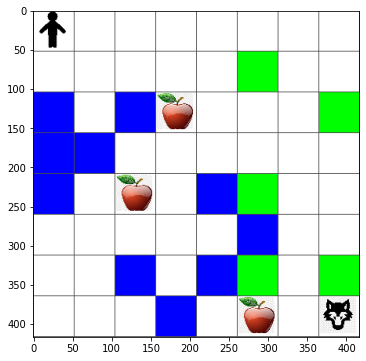

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Actions and Policy

In our example, Peter's goal is to find an apple while avoiding the wolf and other obstacles. To achieve this, he can essentially wander around until he finds an apple. At any given position, he can choose one of the following actions: up, down, left, or right. We will define these actions as a dictionary and map them to pairs of corresponding coordinate changes. For instance, moving right (`R`) corresponds to the pair `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

The strategy of our agent (Peter) is defined by what is called a **policy**. Let's take a look at the simplest policy, known as the **random walk**.

## Random walk

Let's start solving our problem by implementing a random walk strategy.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Let's run random walk experiment several times and see the average number of steps taken:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Reward Function

To make our policy smarter, we need to identify which actions are "better" than others.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Create a Q-Table, or a multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent the Q-Table using a numpy array with the shape `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Pass the Q-Table to the plot function in order to visualize the table on the board:


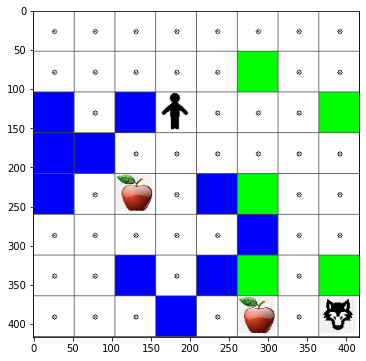

In [9]:
m.plot(Q)

## Essence of Q-Learning: Bellman Equation and Learning Algorithm

Write a pseudo-code for our learning algorithm:

* Initialize Q-Table Q with equal values for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at a random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Execute the action by moving to a new state $s'$
        3. If we encounter an end-of-game condition, or the total reward is too small - exit the simulation  
        4. Compute the reward $r$ at the new state
        5. Update the Q-Function according to the Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update the total reward and decrease $\alpha$.

## Exploit vs. Explore

The best approach is to strike a balance between exploration and exploitation. As we gain more knowledge about our environment, we are more likely to follow the optimal path, but occasionally choosing an unexplored route can be beneficial.

## Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need a function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for the corresponding actions:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a small amount of `eps` to the original vector to prevent division by zero in the initial scenario, where all components of the vector are the same.

The learning algorithm itself will be executed for 5000 experiments, also referred to as **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Visualize the table here:


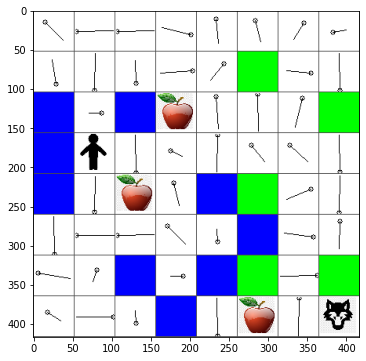

In [12]:
m.plot(Q)

## Checking the Policy

Since the Q-Table lists the "attractiveness" of each action for every state, it’s quite straightforward to use it to determine efficient navigation in our environment. In the simplest scenario, we can simply choose the action that corresponds to the highest value in the Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press the STOP button in the notebook to interrupt it.

> **Task 1:** Modify the `walk` function to limit the maximum length of the path to a certain number of steps (e.g., 100), and observe how the code above occasionally returns this value.

> **Task 2:** Modify the `walk` function so that it avoids revisiting locations it has already been to. This will prevent `walk` from looping, although the agent may still end up "trapped" in a location it cannot escape from.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


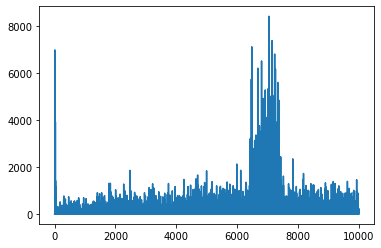

In [15]:
plt.plot(lpath)

What we observe here is that initially, the average path length increased. This is likely because, when we have no knowledge of the environment, we tend to fall into unfavorable situations, such as encountering water or wolves. As we gain more knowledge and start applying it, we can explore the environment for longer periods, but we still lack a clear understanding of where the apples are located.

Once we acquire sufficient knowledge, it becomes easier for the agent to achieve its goal, and the path length begins to decrease. However, since exploration is still ongoing, we often deviate from the optimal path and test new possibilities, which can make the path longer than necessary.

Another observation from this graph is that, at some point, the path length increased suddenly. This reflects the stochastic nature of the process and suggests that the Q-Table coefficients can occasionally be "spoiled" by being overwritten with new values. Ideally, this should be mitigated by reducing the learning rate (i.e., towards the end of training, we adjust the Q-Table values by smaller increments).

In general, it is crucial to remember that the success and quality of the learning process depend heavily on parameters such as the learning rate, learning rate decay, and discount factor. These are often referred to as **hyperparameters** to differentiate them from **parameters**, which are optimized during training (e.g., Q-Table coefficients). The process of determining the best hyperparameter values is known as **hyperparameter optimization**, and it is a topic worthy of separate discussion.


## Exercise
#### A More Realistic Peter and the Wolf World

In our scenario, Peter could move around almost endlessly without getting tired or hungry. In a more realistic world, he would need to stop and rest occasionally, as well as eat to sustain himself. Let's make our world more realistic by implementing the following rules:

1. Moving from one location to another causes Peter to lose **energy** and gain **fatigue**.
2. Peter can restore energy by eating apples.
3. Peter can reduce fatigue by resting under a tree or on the grass (i.e., stepping into a board location with a tree or grass - green field).
4. Peter must locate and defeat the wolf.
5. To defeat the wolf, Peter needs to have specific levels of energy and fatigue; otherwise, he will lose the battle.

Update the reward function above to reflect the game's rules, run the reinforcement learning algorithm to determine the optimal strategy for winning the game, and compare the results of random movement with your algorithm in terms of the number of games won and lost.

> **Note**: You may need to tweak hyperparameters to make it work, especially the number of epochs. Since the game's success (defeating the wolf) is a rare event, you should anticipate a significantly longer training time.



---

**Disclaimer**:  
This document has been translated using the AI translation service [Co-op Translator](https://github.com/Azure/co-op-translator). While we strive for accuracy, please note that automated translations may contain errors or inaccuracies. The original document in its native language should be regarded as the authoritative source. For critical information, professional human translation is recommended. We are not responsible for any misunderstandings or misinterpretations resulting from the use of this translation.
